In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import cv2   # for CLAHE

import os
import random 
import glob
from itertools import product  # for confusion matrix plot
from itertools import islice
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# for LIME
from lime import lime_image
explainer = lime_image.LimeImageExplainer(random_state=2021)
from skimage.segmentation import mark_boundaries

import warnings
warnings.simplefilter("ignore")

print("TF version: ", tf.__version__)
print('Hub version:', hub.__version__)

TF version:  2.6.2
Hub version: 0.12.0


#### Path for EfficientNet V2 model weights

In [2]:
## Mapping copied from a "TF Hub for TF2: Retraining an image classifier" colab example
## For efficientnet class of models

def get_hub_url_and_isize(model_name, ckpt_type, hub_type):
  if ckpt_type == '1k':
    ckpt_type = ''  # json doesn't support empty string
  else:
    ckpt_type = '-' + ckpt_type  # add '-' as prefix
  
  hub_url_map = {
    'efficientnetv2-b0': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/{hub_type}',
    'efficientnetv2-b1': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1/{hub_type}',
    'efficientnetv2-b2': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2/{hub_type}',
    'efficientnetv2-b3': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3/{hub_type}',
    'efficientnetv2-s':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s/{hub_type}',
    'efficientnetv2-m':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m/{hub_type}',
    'efficientnetv2-l':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l/{hub_type}',

    'efficientnetv2-b0-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k/{hub_type}',
    'efficientnetv2-b1-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k/{hub_type}',
    'efficientnetv2-b2-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k/{hub_type}',
    'efficientnetv2-b3-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k/{hub_type}',
    'efficientnetv2-s-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k/{hub_type}',
    'efficientnetv2-m-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k/{hub_type}',
    'efficientnetv2-l-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k/{hub_type}',
    'efficientnetv2-xl-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k/{hub_type}',

    'efficientnetv2-b0-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k-ft1k/{hub_type}',
    'efficientnetv2-b1-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k-ft1k/{hub_type}',
    'efficientnetv2-b2-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k-ft1k/{hub_type}',
    'efficientnetv2-b3-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k-ft1k/{hub_type}',
    'efficientnetv2-s-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k-ft1k/{hub_type}',
    'efficientnetv2-m-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k-ft1k/{hub_type}',
    'efficientnetv2-l-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/{hub_type}',
    'efficientnetv2-xl-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k-ft1k/{hub_type}',
      
    # efficientnetv1
    'efficientnet_b0': f'https://tfhub.dev/tensorflow/efficientnet/b0/{hub_type}/1',
    'efficientnet_b1': f'https://tfhub.dev/tensorflow/efficientnet/b1/{hub_type}/1',
    'efficientnet_b2': f'https://tfhub.dev/tensorflow/efficientnet/b2/{hub_type}/1',
    'efficientnet_b3': f'https://tfhub.dev/tensorflow/efficientnet/b3/{hub_type}/1',
    'efficientnet_b4': f'https://tfhub.dev/tensorflow/efficientnet/b4/{hub_type}/1',
    'efficientnet_b5': f'https://tfhub.dev/tensorflow/efficientnet/b5/{hub_type}/1',
    'efficientnet_b6': f'https://tfhub.dev/tensorflow/efficientnet/b6/{hub_type}/1',
    'efficientnet_b7': f'https://tfhub.dev/tensorflow/efficientnet/b7/{hub_type}/1',
  }
  
  image_size_map = {
    'efficientnetv2-b0': 224,
    'efficientnetv2-b1': 240,
    'efficientnetv2-b2': 260,
    'efficientnetv2-b3': 300,
    'efficientnetv2-s':  384,
    'efficientnetv2-m':  480,
    'efficientnetv2-l':  480,
    'efficientnetv2-xl':  512,
  
    'efficientnet_b0': 224,
    'efficientnet_b1': 240,
    'efficientnet_b2': 260,
    'efficientnet_b3': 300,
    'efficientnet_b4': 380,
    'efficientnet_b5': 456,
    'efficientnet_b6': 528,
    'efficientnet_b7': 600,
  }
  

  hub_url = hub_url_map.get(model_name + ckpt_type)
  image_size = image_size_map.get(model_name)
  return hub_url, image_size

In [3]:
CONFIG = dict (
    seed = 2021,    
    num_classes = 4,
    train_val_split = 0.2,
    batch_size = 8,
    epochs = 30, 
    learning_rate = 1e-5,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'sparse_categorical_accuracy',
    optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
)


# Config for pretrained model 
CONFIG['model_type'] = 'efficientnetv2-b0'
CONFIG['ckpt_type'] = '1k'   # '1k', '21k-ft1k', '21k'
CONFIG['hub_type'] = 'feature-vector' 
hub_url, image_size = get_hub_url_and_isize(CONFIG['model_type'], CONFIG['ckpt_type'], CONFIG['hub_type'])
print(f'Hub URL: {hub_url}')
CONFIG['img_width'] = image_size
CONFIG['img_height'] = image_size
CONFIG['img_size'] = image_size
CONFIG['do_fine_tuning'] = True



def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    #os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    
seed_everything(CONFIG['seed'])

#CSV_FILE = '../input/sartorius-cell-instance-segmentation/train.csv'
TRAIN_PATH = "/kaggle/input/hushem-aug/train"
TEST_PATH = "/kaggle/input/hushem-aug/test"
AUTOTUNE = tf.data.experimental.AUTOTUNE

TRAIN_MODEL = False # if False, use saved model for LIME; if true, train a new model

Hub URL: gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/feature-vector


## Part I: EDA, data preprocessing (tf.data)

In [4]:
import os
import glob

# Specify the paths for training and testing
#TRAIN_PATH = "/content/drive/MyDrive/me/HusHem2/train"
#TEST_PATH = "/content/drive/MyDrive/me/HusHem2/test"

# Create a list of subdirectories within the TRAIN_PATH
subdirectories = [subdir for subdir in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, subdir))]

# Initialize empty lists to store train and test image paths
train_images = []
test_images = []

# Iterate through the subdirectories
for subdir in subdirectories:
    # Create the full path for train and test sets
    train_subpath = os.path.join(TRAIN_PATH, subdir)
    test_subpath = os.path.join(TEST_PATH, subdir)

    # Use glob to find .BMP files in the subdirectories
    train_images.extend(glob.glob(os.path.join(train_subpath, '*.BMP')))
    test_images.extend(glob.glob(os.path.join(test_subpath, '*.BMP')))

# Print the first few paths to verify the results
print("Train images:")
print(train_images[:5])

print("Test images:")
print(test_images[:5])

# Print the shapes of the images
for image_path in train_images[:5]:
    image = cv2.imread(image_path)
    print(f"Image shape: {image.shape}")

Train images:
['/kaggle/input/hushem-aug/train/01_Normal/image_051_augmented_234.BMP', '/kaggle/input/hushem-aug/train/01_Normal/image_009_augmented_210.BMP', '/kaggle/input/hushem-aug/train/01_Normal/image_019_augmented_196.BMP', '/kaggle/input/hushem-aug/train/01_Normal/image_037_augmented_39.BMP', '/kaggle/input/hushem-aug/train/01_Normal/image_037_augmented_120.BMP']
Test images:
['/kaggle/input/hushem-aug/test/01_Normal/image_031_augmented_101.BMP', '/kaggle/input/hushem-aug/test/01_Normal/image_045_augmented_169.BMP', '/kaggle/input/hushem-aug/test/01_Normal/image_041_augmented_124.BMP', '/kaggle/input/hushem-aug/test/01_Normal/image_017_augmented_80.BMP', '/kaggle/input/hushem-aug/test/01_Normal/image_024_augmented_218.BMP']
Image shape: (131, 131, 3)
Image shape: (131, 131, 3)
Image shape: (131, 131, 3)
Image shape: (131, 131, 3)
Image shape: (131, 131, 3)


In [5]:
def generate_labels(image_paths):
    # Extract the class labels from the image paths
    class_labels = [path.split('/')[-2] for path in image_paths]

    # Define a mapping from class labels to integer labels
    class_mapping = {
        '01_Normal': 0,
        '02_Tapered': 1,
        '03_Pyriform': 2,
        '04_Amorphous': 3
    }

    # Map the class labels to integer labels using the mapping
    labels = [class_mapping[label] for label in class_labels]

    return labels

def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # Shuffle and return df
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Build the DataFrames
df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))
# View first 5 samples in the training set
df.head(20)

,image_path,label
0,/kaggle/input/hushem-aug/train/03_Pyriform/ima...,2
1,/kaggle/input/hushem-aug/train/01_Normal/image...,0
2,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1
3,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1
4,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1
5,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1
6,/kaggle/input/hushem-aug/train/04_Amorphous/im...,3
7,/kaggle/input/hushem-aug/train/03_Pyriform/ima...,2
8,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1
9,/kaggle/input/hushem-aug/train/01_Normal/image...,0


In [ ]:
col_list = ['id', 'cell_type']
df = pd.read_csv(CSV_FILE, usecols=col_list)
df['path'] = TRAIN_PATH + df['id'] + '.png'

df.rename(columns = {"cell_type": "label"}, inplace = True)
print(f'The dataset has {df.shape[0]} entries.\n')

CLASSES = df['label'].unique()
print(f'The labels are: {CLASSES[0]}, {CLASSES[1]}, {CLASSES[2]}')

In [7]:
CLASSES = df['label'].unique()

In [8]:
# dict to encode labels
label_dict = {'01_Normal': 0, '02_Tapered': 1, '03_Pyriform':2, '04_Amorphous':3}
df['label'] = df['label'].replace(label_dict)

# reverse dict to get back original labels
rev_label_dict = dict((v,k) for k,v in label_dict.items())

df.head()

,image_path,label
0,/kaggle/input/hushem-aug/train/03_Pyriform/ima...,2
1,/kaggle/input/hushem-aug/train/01_Normal/image...,0
2,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1
3,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1
4,/kaggle/input/hushem-aug/train/02_Tapered/imag...,1


#### Visualize each image class

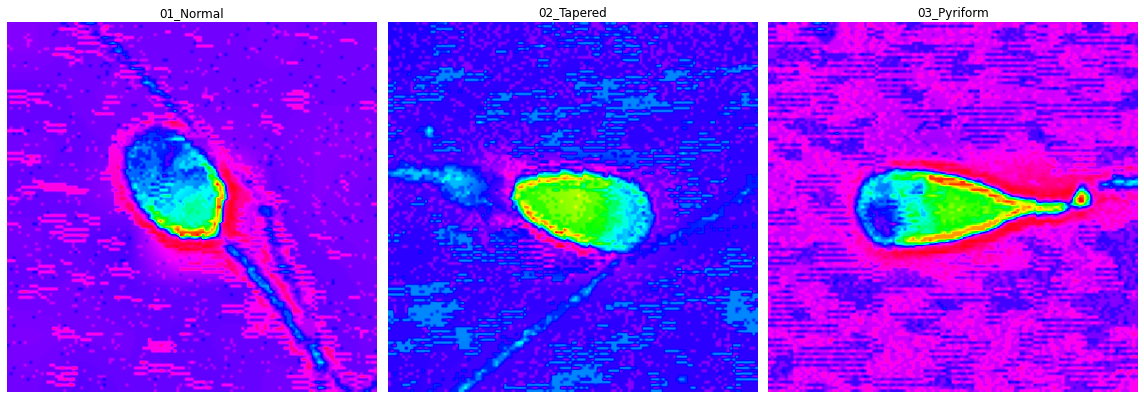

In [9]:
import matplotlib.pyplot as plt

# Initialize a figure
plt.figure(figsize=(16, 12))

for i in range(3):
    # Get the first instance for each label
    df_temp_ = df.loc[df.label == i].head(1)
    
    # Check if there is any data for this label
    if not df_temp_.empty:
        filename = df_temp_['image_path'].values[0]  # Get the 'path' column value
    
        # CLAHE to enhance the image
        img = cv2.imread(filename)[..., 0]
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        img2 = clahe.apply(img)
    
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(img2, cmap='hsv')
        plt.title(rev_label_dict.get(i))
        plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


<a id='visualization'></a>

In [10]:
X_train, X_valid = train_test_split(df, 
                                    test_size=CONFIG['train_val_split'], 
                                    random_state=CONFIG['seed'], 
                                    shuffle=True)


train_ds = tf.data.Dataset.from_tensor_slices((X_train.image_path.values, X_train.label.values))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid.image_path.values, X_valid.label.values))

# print path/label
for image_path, label in train_ds.take(3):
    print ('Path: {}, Label: {}'.format(image_path, label))

Path: b'/kaggle/input/hushem-aug/train/03_Pyriform/image_004_augmented_53.BMP', Label: 2
Path: b'/kaggle/input/hushem-aug/train/02_Tapered/image_043_augmented_12.BMP', Label: 1
Path: b'/kaggle/input/hushem-aug/train/02_Tapered/image_008_augmented_29.BMP', Label: 1


In [11]:
def preprocess_data_train(image_path, label):
    # load the raw data as a string
    img = tf.io.read_file(image_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0 
    # augment data in CPU
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_flip_left_right(img, seed=None)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.resize(img, [CONFIG['img_size'],CONFIG['img_size']])
    return img, label

def preprocess_data_valid(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [CONFIG['img_size'],CONFIG['img_size']])
    return img, label


# set num_parallel_calls to process multiple images in parallel
train_ds = train_ds.map(preprocess_data_train, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(preprocess_data_valid, num_parallel_calls=AUTOTUNE)

In [12]:
def configure_for_performance(ds, batch_size = 8):    
    ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds_batch = configure_for_performance(train_ds, CONFIG['batch_size'])
valid_ds_batch = valid_ds.batch(CONFIG['batch_size'])

#### Plot augmented images
A sanity check on the image pipeline where the images have been loaded, preprocessed (resized), batched and augmented (brightness, vertical/horizontal flips).

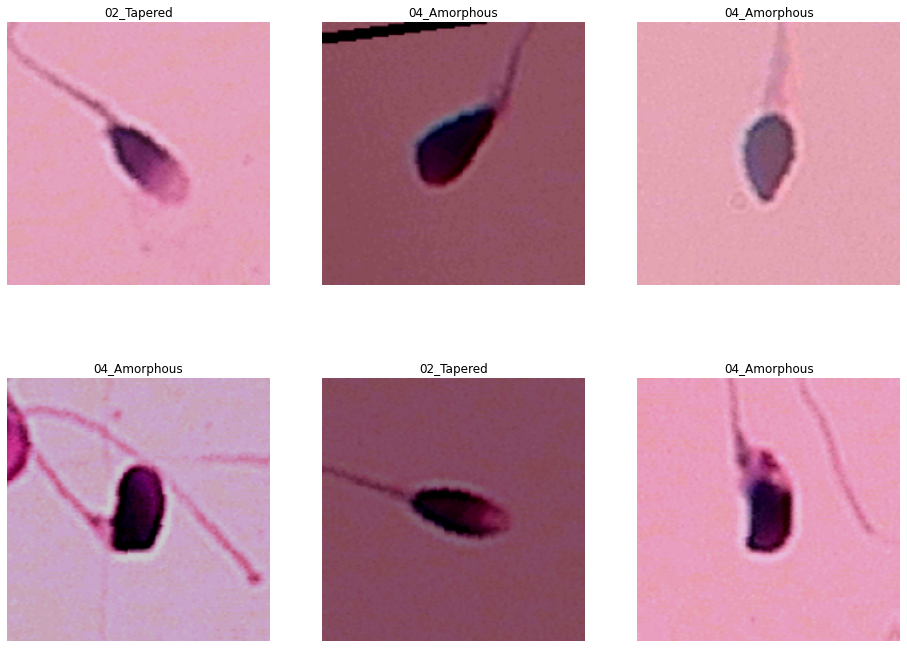

In [13]:
image_batch, label_batch = next(iter(train_ds_batch))

plt.figure(figsize=(16, 12))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy(), cmap='bone_r')
    label = label_batch[i].numpy()
    plt.title(rev_label_dict.get(label))
    plt.axis("off");

## Part II: Model training

In [56]:
base_model = hub.KerasLayer(hub_url, trainable=True,
                           input_shape=(CONFIG['img_width'], CONFIG['img_height'], 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(CONFIG['num_classes'], activation='softmax')
])


model.compile(
    optimizer=CONFIG['optimizer'],
    loss=CONFIG['loss'],
    metrics=CONFIG['metrics'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 6,248,276
Trainable params: 6,187,668
Non-trainable params: 60,608
_________________________________________________________________


In [30]:
import tensorflow as tf
from tensorflow import keras

# Define your CNN model
model = tf.keras.Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(CONFIG['img_width'], CONFIG['img_height'], 3)))

# Add a max-pooling layer with a 2x2 pool size
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Add another convolutional layer with 64 filters and a 3x3 kernel
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

# Add a max-pooling layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Add a dropout layer with a dropout rate of 0.3
model.add(tf.keras.layers.Dropout(rate=0.3))

# Flatten the output
model.add(tf.keras.layers.Flatten())

# Add a dense layer with 256 units and ReLU activation
model.add(tf.keras.layers.Dense(256, activation='relu'))

# Add another dropout layer
model.add(tf.keras.layers.Dropout(rate=0.3))

# Add the output layer with the specified number of classes and softmax activation
model.add(tf.keras.layers.Dense(CONFIG['num_classes'], activation='softmax'))

# Compile the model with the specified optimizer, loss, and metrics
model.compile(
    optimizer=CONFIG['optimizer'],
    loss=CONFIG['loss'],
    metrics=CONFIG['metrics'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               4

In [46]:
import tensorflow as tf

# Define the U-Net model
def unet_model(input_shape=None, num_classes=None):
    if input_shape is None:
        input_shape = (CONFIG['img_width'], CONFIG['img_height'], 3)
    if num_classes is None:
        num_classes = CONFIG['num_classes']

    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Expansive Path
    up4 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = tf.keras.layers.concatenate([up4, conv2], axis=-1)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv1], axis=-1)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer (modified)
    outputs = tf.keras.layers.Conv2D(CONFIG['num_classes'], 1, activation='softmax')(conv5)  # Assuming 4 classes

    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

# Define the input shape
# input_shape = (256, 256, 3)  # Adjust the input shape as needed
model = unet_model(input_shape=(CONFIG['img_width'], CONFIG['img_height'], 3), num_classes=CONFIG['num_classes'])
model.compile(
    optimizer=CONFIG['optimizer'],
    loss=CONFIG['loss'],
    metrics=CONFIG['metrics'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 224, 224, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_32[0][0]                  
____________________________________________________________________________________________

In [54]:
import tensorflow as tf

# Define the U-Net model
def unet_model(input_shape=None, num_classes=None):
    if input_shape is None:
        input_shape = (CONFIG['img_width'], CONFIG['img_height'], 3)
    if num_classes is None:
        num_classes = CONFIG['num_classes']

    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Expansive Path
    up4 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = tf.keras.layers.concatenate([up4, conv2], axis=-1)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv1], axis=-1)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Global Average Pooling
    gap = tf.keras.layers.GlobalAveragePooling2D()(conv5)

    # Output Dense layer for classification
    outputs = tf.keras.layers.Dense(CONFIG['num_classes'], activation='softmax')(gap)  # Assuming 4 classes

    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="UNET")

    return model

# Define the input shape
# input_shape = (256, 256, 3)  # Adjust the input shape as needed
model = unet_model(input_shape=(CONFIG['img_width'], CONFIG['img_height'], 3), num_classes=CONFIG['num_classes'])
model.compile(
    optimizer=CONFIG['optimizer'],
    loss=CONFIG['loss'],
    metrics=CONFIG['metrics'])
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 224, 224, 64) 1792        input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_54[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_55[0][0]                  
_______________________________________________________________________________________________

**VGG16 AS ENCODER & FCN 8 DECODER**

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (CONFIG['img_width'], CONFIG['img_height'], 3)

# Generate a new model using the VGG network
inputs = Input(input_shape)

# VGG network
vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output
c2 = vgg16_model.get_layer("block4_pool").output
c3 = vgg16_model.get_layer("block5_pool").output

# Decoder
u1 = UpSampling2D((2, 2), interpolation='bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation='bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation='bilinear')(d2)
outputs = Conv2D(CONFIG['num_classes'], 1, activation='sigmoid')(u3)

# Create the model
model = Model(inputs, outputs, name="VGG_FCN8")

# Compile the model
model.compile(
    optimizer=CONFIG['optimizer'],
    loss=CONFIG['loss'],
    metrics=CONFIG['metrics']
)

# Print model summary
model.summary()

Model: "VGG_FCN8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [55]:
weight_path_save = 'best_model.hdf5'
last_weight_path = 'last_model.hdf5'

checkpoint = ModelCheckpoint(weight_path_save, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)
checkpoint_last = ModelCheckpoint(last_weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode= 'min', 
                             save_weights_only = False)


early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=2, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.00001)
callbacks_list = [checkpoint, checkpoint_last, early, reduce_lr]

In [56]:
# plot train and validation curves

def plot_hist(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1,len(loss)+1)

    fig = plt.figure(figsize=(9, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, linestyle='--', linewidth=3, color='red', alpha=0.7, label='Train Loss')
    plt.plot(epochs, val_loss, linestyle='/dashdot', linewidth=2, color='green', alpha=0.8, label='Valid Loss')
    plt.xlim(1, max(plt.xlim()))
    plt.ylim(0,max(max(plt.ylim()), 0.01))
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training/Validation Loss')
    plt.legend(fontsize=12)


    plt.subplot(1, 2, 2) 
    plt.plot(epochs, acc, linestyle='--', linewidth=3, color='red', alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_acc, linestyle='solid', linewidth=4, color='green', alpha=0.8, label='Valid Acc') 
    plt.xlim(1, max(plt.xlim()))
    plt.ylim(min(min(plt.ylim()), 0.98),1)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training/Validation Accuracy')
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [58]:
def plot_hist(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1,len(loss)+1)

    fig = plt.figure(figsize=(9, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, linestyle='--', linewidth=3, color='red', alpha=0.7, label='Train Loss')
    plt.plot(epochs, val_loss, linestyle='--', linewidth=2, color='green', alpha=0.8, label='Valid Loss')
    plt.xlim(1, max(plt.xlim()))
    plt.ylim(0,max(max(plt.ylim()), 0.01))
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training/Validation Loss')
    plt.legend(fontsize=12)

    plt.subplot(1, 2, 2) 
    plt.plot(epochs, acc, linestyle='--', linewidth=3, color='red', alpha=0.7, label='Train Acc')
    plt.plot(epochs, val_acc, linestyle='solid', linewidth=4, color='green', alpha=0.8, label='Valid Acc') 
    plt.xlim(1, max(plt.xlim()))
    plt.ylim(min(min(plt.ylim()), 0.98),1)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training/Validation Accuracy')
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()


Epoch 1/30
79/79 [==============================] - 17s 72ms/step - loss: 1.2916 - sparse_categorical_accuracy: 0.4108 - val_loss: 1.0108 - val_sparse_categorical_accuracy: 0.6688

Epoch 00001: val_loss improved from inf to 1.01077, saving model to best_model.hdf5

Epoch 00001: saving model to last_model.hdf5
Epoch 2/30
79/79 [==============================] - 5s 58ms/step - loss: 0.8621 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.5422 - val_sparse_categorical_accuracy: 0.8089

Epoch 00002: val_loss improved from 1.01077 to 0.54224, saving model to best_model.hdf5

Epoch 00002: saving model to last_model.hdf5
Epoch 3/30
79/79 [==============================] - 5s 57ms/step - loss: 0.5555 - sparse_categorical_accuracy: 0.7930 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 0.8917

Epoch 00003: val_loss improved from 0.54224 to 0.34795, saving model to best_model.hdf5

Epoch 00003: saving model to last_model.hdf5
Epoch 4/30
79/79 [==============================] - 5s 57ms/s

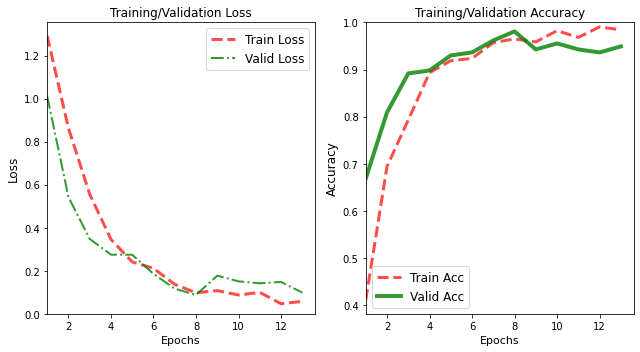

In [69]:
history = model.fit(train_ds_batch, 
                        validation_data = valid_ds_batch, 
                        epochs = CONFIG['epochs'], 
                        callbacks = callbacks_list,
                       )
plot_hist(history)

Epoch 1/30
79/79 [==============================] - 3s 24ms/step - loss: 1.6334 - sparse_categorical_accuracy: 0.2564 - val_loss: 1.3811 - val_sparse_categorical_accuracy: 0.2866

Epoch 00001: val_loss improved from inf to 1.38111, saving model to best_model.hdf5

Epoch 00001: saving model to last_model.hdf5
Epoch 2/30
79/79 [==============================] - 3s 18ms/step - loss: 1.3549 - sparse_categorical_accuracy: 0.3264 - val_loss: 1.3191 - val_sparse_categorical_accuracy: 0.4586

Epoch 00002: val_loss improved from 1.38111 to 1.31907, saving model to best_model.hdf5

Epoch 00002: saving model to last_model.hdf5
Epoch 3/30
79/79 [==============================] - 2s 18ms/step - loss: 1.2802 - sparse_categorical_accuracy: 0.4172 - val_loss: 1.2406 - val_sparse_categorical_accuracy: 0.5159

Epoch 00003: val_loss improved from 1.31907 to 1.24062, saving model to best_model.hdf5

Epoch 00003: saving model to last_model.hdf5
Epoch 4/30
79/79 [==============================] - 2s 20ms/st

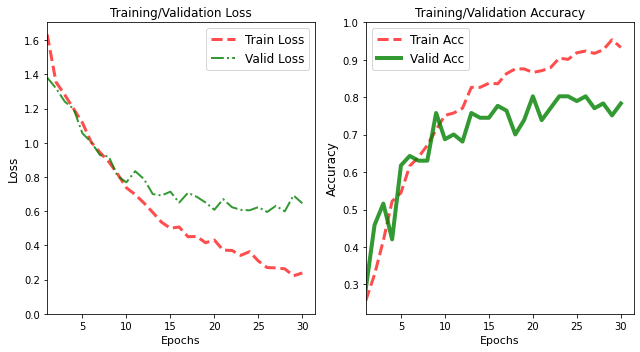

In [33]:
#CNN 
history = model.fit(train_ds_batch, 
                        validation_data = valid_ds_batch, 
                        epochs = CONFIG['epochs'], 
                        callbacks = callbacks_list,
                       )
plot_hist(history)

Epoch 1/30
79/79 [==============================] - 9s 103ms/step - loss: 1.1257 - sparse_categorical_accuracy: 0.4745 - val_loss: 1.1198 - val_sparse_categorical_accuracy: 0.5096

Epoch 00001: val_loss did not improve from 1.11090

Epoch 00001: saving model to last_model.hdf5
Epoch 2/30
79/79 [==============================] - 9s 102ms/step - loss: 1.1271 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.1178 - val_sparse_categorical_accuracy: 0.4968

Epoch 00002: val_loss did not improve from 1.11090

Epoch 00002: saving model to last_model.hdf5
Epoch 3/30
79/79 [==============================] - 9s 103ms/step - loss: 1.1273 - sparse_categorical_accuracy: 0.4697 - val_loss: 1.1443 - val_sparse_categorical_accuracy: 0.4777

Epoch 00003: val_loss did not improve from 1.11090

Epoch 00003: saving model to last_model.hdf5
Epoch 4/30
79/79 [==============================] - 9s 102ms/step - loss: 1.1402 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.1056 - val_sparse_categorical_acc

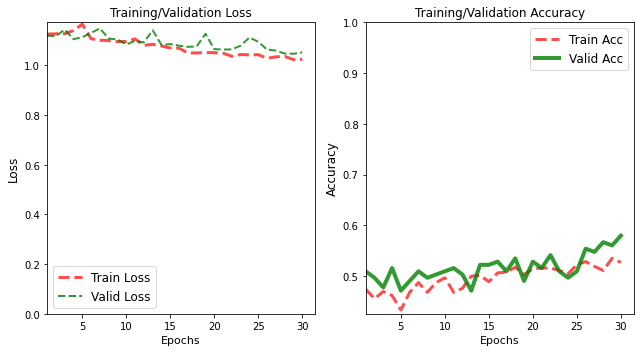

In [59]:
# UNET
history = model.fit(train_ds_batch, 
                        validation_data = valid_ds_batch, 
                        epochs = CONFIG['epochs'], 
                        callbacks = callbacks_list,
                       )
plot_hist(history)

In [60]:
if TRAIN_MODEL:
    history = model.fit(train_ds_batch, 
                        validation_data = valid_ds_batch, 
                        epochs = CONFIG['epochs'], 
                        callbacks = callbacks_list,
                       )
    plot_hist(history)

## Part III: Explainability with LIME

### Evaluating Model on Validation Set

In [61]:
def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy  
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'
           .format(accuracy, misclass),fontsize=15)
    plt.ylabel('True label', fontsize=15)
    plt.title(title, fontsize=22);
    plt.colorbar()

    thresh = cm.max() / 2.0
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
   

In [72]:
if TRAIN_MODEL: 
    model.load_weights(weight_path_save) # load the best model 
else: 
    model.load_weights('/kaggle/working/best_model.hdf5') # load a previously trained model
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 6,248,276
Trainable params: 6,187,668
Non-trainable params: 60,608
_________________________________________________________________


In [36]:
# CNN
if TRAIN_MODEL: 
    model.load_weights(weight_path_save) # load the best model 
else: 
    model.load_weights('/kaggle/working/best_model.hdf5') # load a previously trained model
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               4

In [62]:
# UNET
if TRAIN_MODEL: 
    model.load_weights(weight_path_save) # load the best model 
else: 
    model.load_weights('/kaggle/working/best_model.hdf5') # load a previously trained model
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 224, 224, 64) 1792        input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_54[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_55[0][0]                  
_______________________________________________________________________________________________

In [73]:
pred_prob = model.predict(valid_ds_batch, workers=4, verbose = True)
pred_labels = np.argmax(pred_prob, axis=-1)

valid_labels = np.concatenate([y.numpy() for x, y in valid_ds_batch], axis=0)
print('\n', classification_report(valid_labels, pred_labels ))

20/20 [==============================] - 0s 15ms/step

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      1.00      0.98        42
           2       0.97      0.97      0.97        37
           3       1.00      0.95      0.98        42

    accuracy                           0.98       157
   macro avg       0.98      0.98      0.98       157
weighted avg       0.98      0.98      0.98       157



In [37]:
# CNN
pred_prob = model.predict(valid_ds_batch, workers=4, verbose = True)
pred_labels = np.argmax(pred_prob, axis=-1)

valid_labels = np.concatenate([y.numpy() for x, y in valid_ds_batch], axis=0)
print('\n', classification_report(valid_labels, pred_labels ))

20/20 [==============================] - 0s 7ms/step

               precision    recall  f1-score   support

           0       0.76      0.89      0.82        36
           1       0.71      0.71      0.71        42
           2       0.83      0.81      0.82        37
           3       0.92      0.81      0.86        42

    accuracy                           0.80       157
   macro avg       0.81      0.81      0.80       157
weighted avg       0.81      0.80      0.80       157



In [63]:
# UNET
pred_prob = model.predict(valid_ds_batch, workers=4, verbose = True)
pred_labels = np.argmax(pred_prob, axis=-1)

valid_labels = np.concatenate([y.numpy() for x, y in valid_ds_batch], axis=0)
print('\n', classification_report(valid_labels, pred_labels ))

20/20 [==============================] - 1s 27ms/step

               precision    recall  f1-score   support

           0       0.49      0.78      0.60        36
           1       0.48      0.24      0.32        42
           2       0.50      0.51      0.51        37
           3       0.76      0.74      0.75        42

    accuracy                           0.56       157
   macro avg       0.56      0.57      0.54       157
weighted avg       0.56      0.56      0.54       157



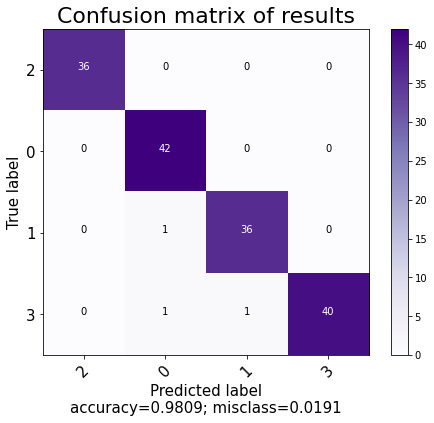

In [76]:
cm = confusion_matrix(valid_labels, pred_labels)
classes = CLASSES
title = 'Confusion matrix of results'
plot_confusion_matrix(cm, classes, title);

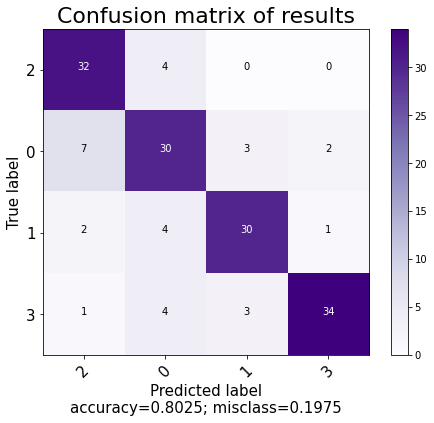

In [38]:
# CNN
cm = confusion_matrix(valid_labels, pred_labels)
classes = CLASSES
title = 'Confusion matrix of results'
plot_confusion_matrix(cm, classes, title);

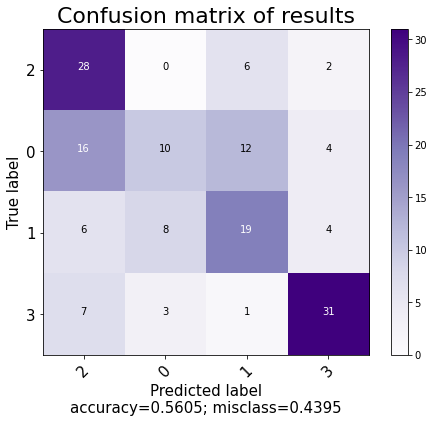

In [64]:
# UNET
cm = confusion_matrix(valid_labels, pred_labels)
classes = CLASSES
title = 'Confusion matrix of results'
plot_confusion_matrix(cm, classes, title);

<a id='PartIII'></a>

#### Select three images

In [65]:
# select a batch of images 
image_iter_2, label_iter_2 = next(islice(valid_ds_batch, 2, None)) # access the 2nd batch from the iterator

image_iter_2 = tf.expand_dims(image_iter_2, 0)
label_iter_2 = label_iter_2.numpy()

# print labels for the batch of 8 images 
print('The labels for the selected batch of 8 images are: ', label_iter_2)

The labels for the selected batch of 8 images are:  [3 3 1 0 2 1 2 2]


In [78]:
# select an image for each unique label
image_idx_selected = [1,4,0]

print(f'The selected images are labeled: ')
for i in image_idx_selected:
    print(f'{rev_label_dict.get(label_iter_2[i])}')

The selected images are labeled: 
04_Amorphous
03_Pyriform
04_Amorphous


In [66]:
# CNN
# select an image for each unique label
image_idx_selected = [1,4,0]

print(f'The selected images are labeled: ')
for i in image_idx_selected:
    print(f'{rev_label_dict.get(label_iter_2[i])}')

The selected images are labeled: 
04_Amorphous
03_Pyriform
04_Amorphous


In [67]:
def explain_image_by_lime(image, label):
    explanation = explainer.explain_instance(image, model.predict, 
                                             top_labels=3, hide_color=0, num_samples=1000)
    
    # show the top 3 superpixels that contribute to the class; do not show the rest of the image
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, num_features=3, hide_rest=True)

    # show the top 3 positive or negative superpixels; make the entire image visible
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, num_features=3, hide_rest=False)
    
  

    fig = plt.figure(figsize=(16, 12), constrained_layout=True)    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('original image', fontsize=14)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp_1, mask_1))
    plt.title('positive superpixels', fontsize=14)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp_2, mask_2), cmap='gray')
    plt.title('positive & negative superpixels', fontsize=14)
    plt.axis('off')
    plt.suptitle(label, y=0.8, fontsize=18)
    plt.show()

#### Image 1

The image selected is labeled: 04_Amorphous



  0%|          | 0/1000 [00:00<?, ?it/s]

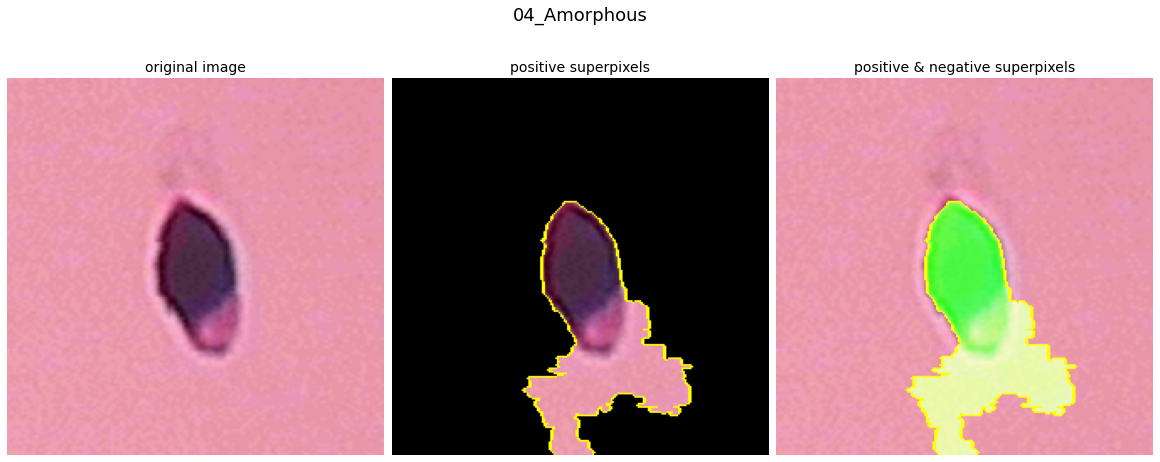

In [80]:
image = image_iter_2[0][1].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[1])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

The image selected is labeled: 04_Amorphous



  0%|          | 0/1000 [00:00<?, ?it/s]

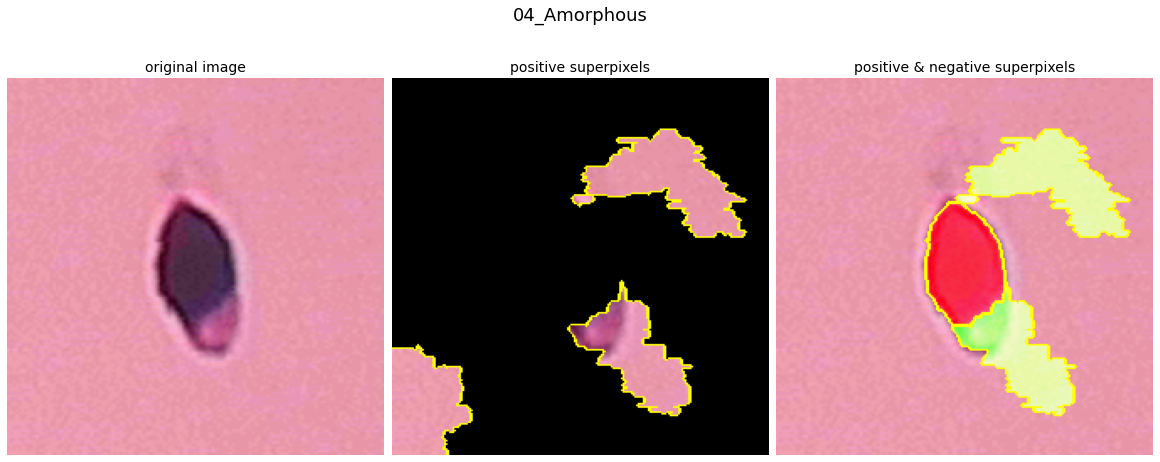

In [42]:
# CNN
image = image_iter_2[0][1].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[1])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

The image selected is labeled: 04_Amorphous



  0%|          | 0/1000 [00:00<?, ?it/s]

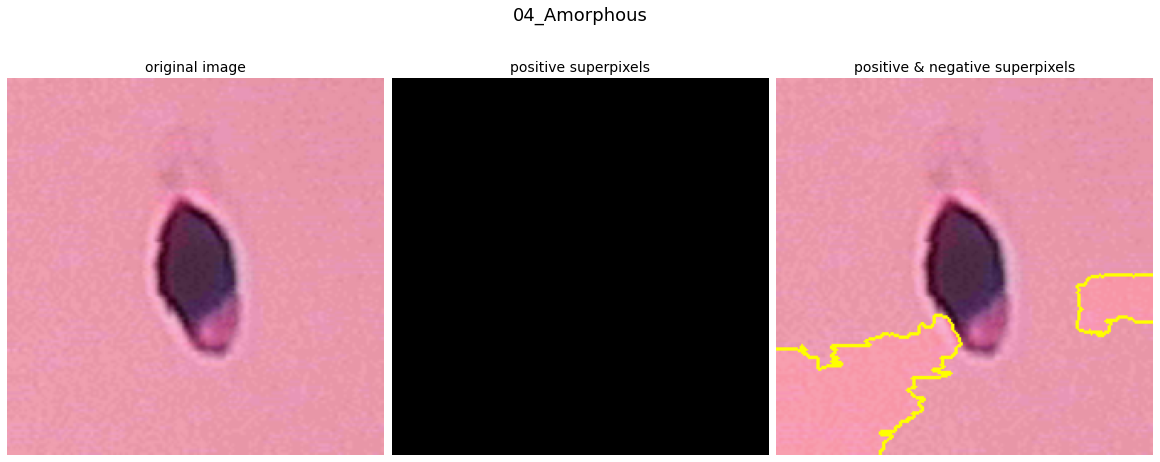

In [68]:
# UNET
image = image_iter_2[0][1].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[1])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

#### Image 2

The image selected is labeled: 03_Pyriform



  0%|          | 0/1000 [00:00<?, ?it/s]

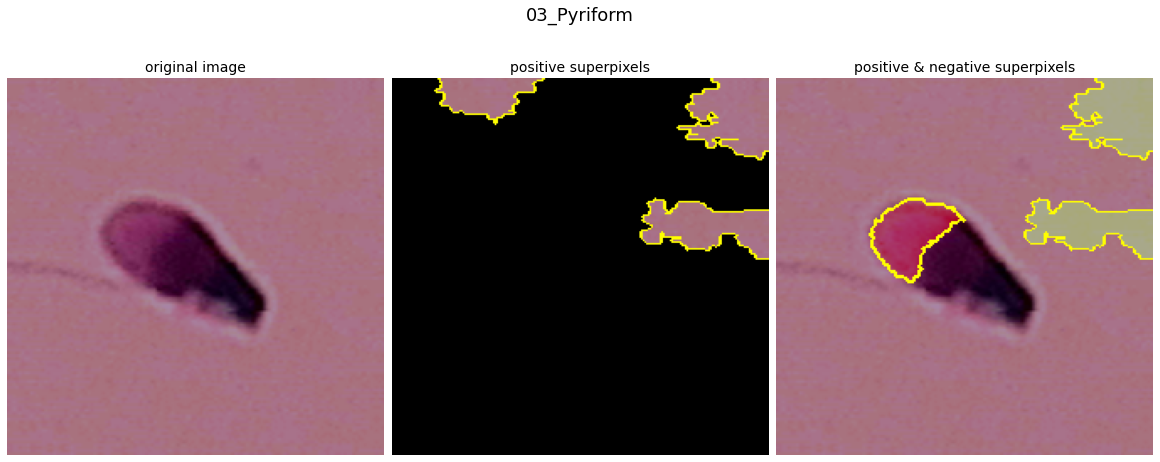

In [81]:
image = image_iter_2[0][4].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[4])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

The image selected is labeled: 03_Pyriform



  0%|          | 0/1000 [00:00<?, ?it/s]

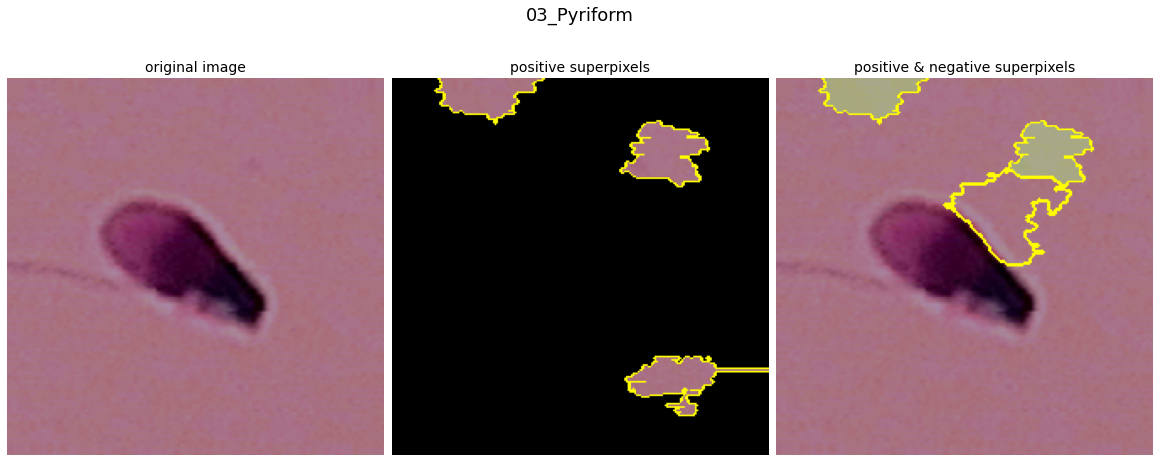

In [43]:
# CNN
image = image_iter_2[0][4].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[4])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

The image selected is labeled: 03_Pyriform



  0%|          | 0/1000 [00:00<?, ?it/s]

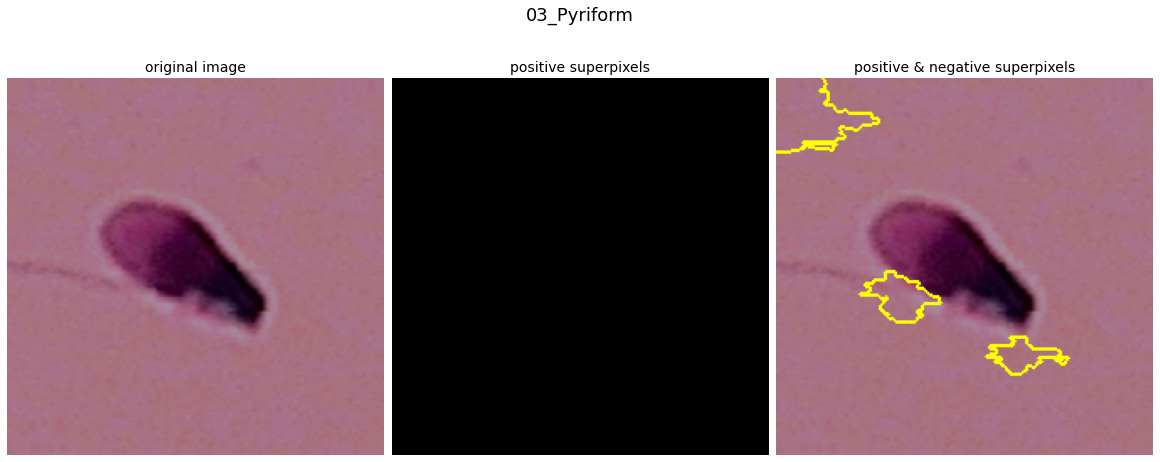

In [69]:
# UNET
image = image_iter_2[0][4].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[4])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

#### Image 3

The image selected is labeled: 04_Amorphous



  0%|          | 0/1000 [00:00<?, ?it/s]

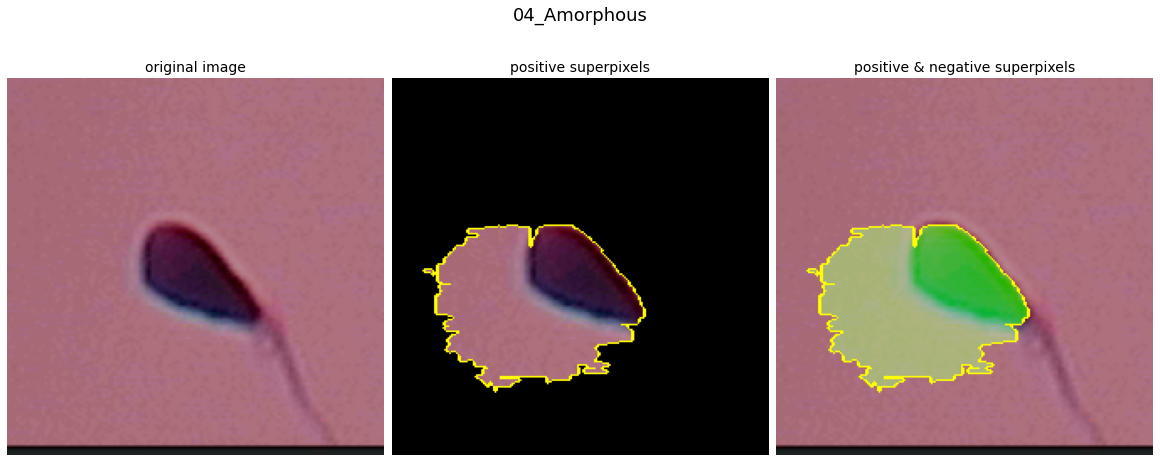

In [82]:
image = image_iter_2[0][0].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[0])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

The image selected is labeled: 04_Amorphous



  0%|          | 0/1000 [00:00<?, ?it/s]

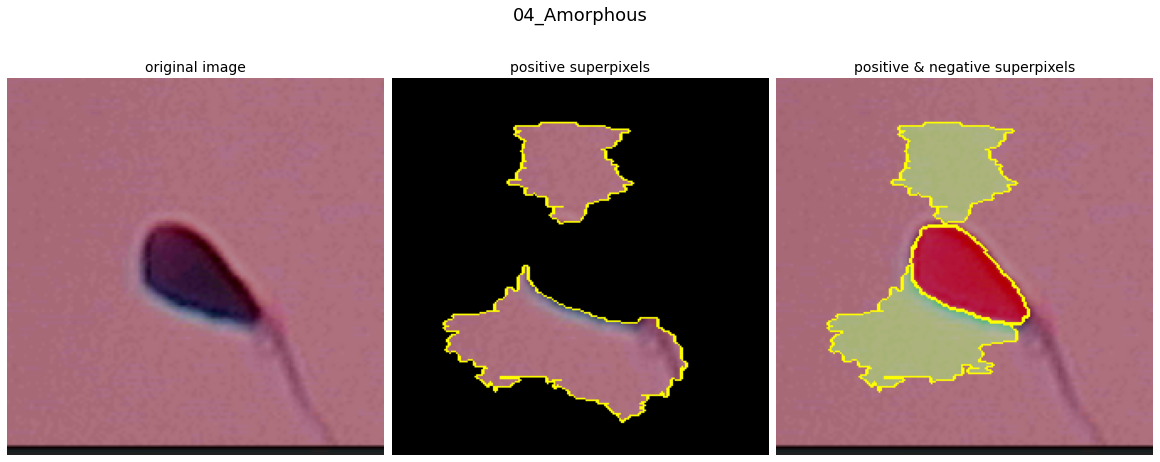

In [44]:
# CNN
image = image_iter_2[0][0].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[0])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)

The image selected is labeled: 04_Amorphous



  0%|          | 0/1000 [00:00<?, ?it/s]

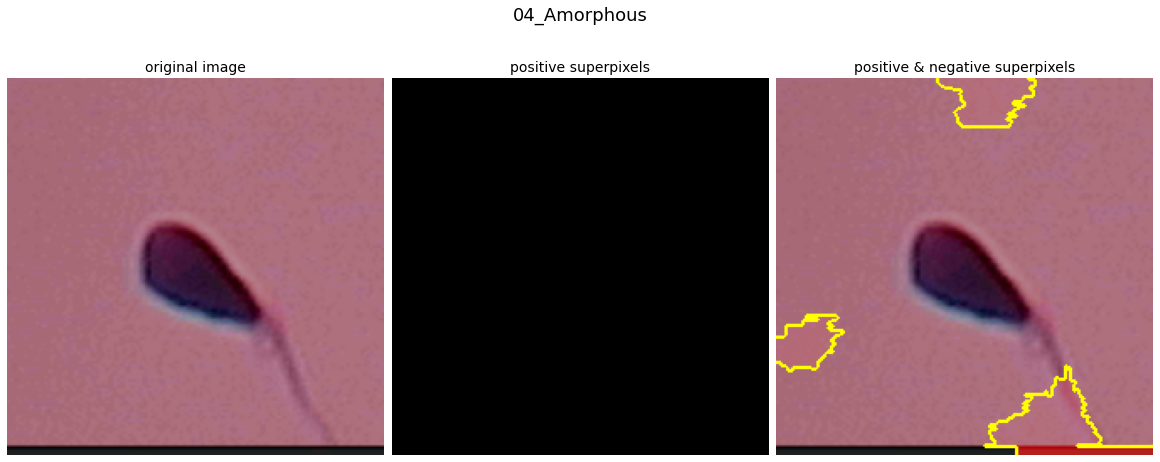

In [70]:
# UNET
image = image_iter_2[0][0].numpy().astype('double')
label = rev_label_dict.get(label_iter_2[0])
print(f'The image selected is labeled: {label}\n')

explain_image_by_lime(image, label)